# Taxi Env (Don't Modify it )

In [16]:
from contextlib import closing
from io import StringIO
from os import path

import numpy as np

import gymnasium as gym
from gymnasium import Env, spaces, utils
from gymnasium.envs.toy_text.utils import categorical_sample
from gymnasium.error import DependencyNotInstalled

MAP_0 = [
    "+---------+",
    "|R: | : :G|",
    "| : | : : |",
    "| : : : : |",
    "| | : | : |",
    "|Y| : |B: |",
    "+---------+",
]

MAP_1 = [
    "+---------+",
    "|R| : : :G|",
    "| | : | : |",
    "| : : | : |",
    "| : | : : |",
    "|Y: | :B: |",
    "+---------+",
]

MAP_2 = [
    "+---------+",
    "|R: : : |G|",
    "| : : : | |",
    "| : | : : |",
    "| : | | : |",
    "|Y: : |B: |",
    "+---------+",
]

MAP = MAP_0
MAPS = [MAP_0, MAP_1, MAP_2]
WINDOW_SIZE = (550, 350)

In [17]:
class TaxiEnv(Env):

    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(
        self,
        render_mode: str | None = None,
        is_rainy: bool = True,
        fickle_passenger: bool = False,
        use_multiple_maps: bool = True,
        reward_step: float = -1,
        reward_delivery: float = 20,
        reward_illegal: float = -10,
    ):
        self.use_multiple_maps = use_multiple_maps

        if use_multiple_maps:
            self.desc_maps = [np.asarray(m, dtype="c") for m in MAPS]
            self.P_maps = []
            self.current_map_id = 0
            self.desc = self.desc_maps[0]
        else:
            self.desc = np.asarray(MAP, dtype="c")

        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3)]
        self.locs_colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 0, 255)]

        self.reward_step = reward_step
        self.reward_delivery = reward_delivery
        self.reward_illegal = reward_illegal

        num_states = 500
        num_rows = 5
        num_columns = 5
        self.max_row = num_rows - 1
        self.max_col = num_columns - 1
        self.initial_state_distrib = np.zeros(num_states)
        num_actions = 6


        if use_multiple_maps:

            for map_idx in range(3):
                self.desc = self.desc_maps[map_idx]
                P = {
                    state: {action: [] for action in range(num_actions)}
                    for state in range(num_states)
                }
                self.P = P

                # Iterate through all possible state combinations
                for row in range(num_rows):
                    for col in range(num_columns):
                        for pass_idx in range(len(locs) + 1):
                            for dest_idx in range(len(locs)):
                                state = self.encode(row, col, pass_idx, dest_idx)
                                if pass_idx < 4 and pass_idx != dest_idx:
                                    self.initial_state_distrib[state] += 1
                                for action in range(num_actions):
                                    if is_rainy:
                                        self._build_rainy_transitions(
                                            row, col, pass_idx, dest_idx, action,
                                        )
                                    else:
                                        self._build_dry_transitions(
                                            row, col, pass_idx, dest_idx, action,
                                        )

                self.P_maps.append(P)


            self.desc = self.desc_maps[0]
            self.P = self.P_maps[0]
        else:

            self.P = {
                state: {action: [] for action in range(num_actions)}
                for state in range(num_states)
            }

            for row in range(num_rows):
                for col in range(num_columns):
                    for pass_idx in range(len(locs) + 1):
                        for dest_idx in range(len(locs)):
                            state = self.encode(row, col, pass_idx, dest_idx)
                            if pass_idx < 4 and pass_idx != dest_idx:
                                self.initial_state_distrib[state] += 1
                            for action in range(num_actions):
                                if is_rainy:
                                    self._build_rainy_transitions(
                                        row, col, pass_idx, dest_idx, action,
                                    )
                                else:
                                    self._build_dry_transitions(
                                        row, col, pass_idx, dest_idx, action,
                                    )

        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.action_space = spaces.Discrete(num_actions)
        self.observation_space = spaces.Discrete(num_states)

        self.render_mode = render_mode
        self.fickle_passenger = fickle_passenger
        self.fickle_step = self.fickle_passenger and self.np_random.random() < 0.5

        # pygame utils
        self.window = None
        self.clock = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.desc.shape[1],
            WINDOW_SIZE[1] / self.desc.shape[0],
        )
        self.taxi_imgs = None
        self.taxi_orientation = 0
        self.passenger_img = None
        self.destination_img = None
        self.median_horiz = None
        self.median_vert = None
        self.background_img = None

    def _pickup(self, taxi_loc, pass_idx, reward):
        """Computes the new location and reward for pickup action."""
        if pass_idx < 4 and taxi_loc == self.locs[pass_idx]:
            new_pass_idx = 4
            new_reward = reward
        else:  # passenger not at location
            new_pass_idx = pass_idx
            new_reward = self.reward_illegal

        return new_pass_idx, new_reward

    def _dropoff(self, taxi_loc, pass_idx, dest_idx, default_reward):
        """Computes the new location and reward for return dropoff action."""
        if (taxi_loc == self.locs[dest_idx]) and pass_idx == 4:
            new_pass_idx = dest_idx
            new_terminated = True
            new_reward = self.reward_delivery
        elif (taxi_loc in self.locs) and pass_idx == 4:
            new_pass_idx = self.locs.index(taxi_loc)
            new_terminated = False
            new_reward = default_reward
        else:  # dropoff at wrong location
            new_pass_idx = pass_idx
            new_terminated = False
            new_reward = self.reward_illegal

        return new_pass_idx, new_reward, new_terminated

    def _calc_new_position(self, row, col, movement, offset=0):
        """Calculates the new position for a row and col to the movement."""
        dr, dc = movement
        new_row = max(0, min(row + dr, self.max_row))
        new_col = max(0, min(col + dc, self.max_col))
        if self.desc[1 + new_row, 2 * new_col + offset] == b":":
            return new_row, new_col
        else:  # Default to current position if not traversable
            return row, col

    def _build_rainy_transitions(self, row, col, pass_idx, dest_idx, action):
        """Computes the next action for a state (row, col, pass_idx, dest_idx) and action for `is_rainy`."""
        state = self.encode(row, col, pass_idx, dest_idx)

        taxi_loc = left_pos = right_pos = (row, col)
        new_row, new_col, new_pass_idx = row, col, pass_idx
        reward = self.reward_step
        terminated = False

        moves = {
            0: ((1, 0), (0, -1), (0, 1)),  # Down
            1: ((-1, 0), (0, -1), (0, 1)),  # Up
            2: ((0, 1), (1, 0), (-1, 0)),  # Right
            3: ((0, -1), (1, 0), (-1, 0)),  # Left
        }

        # Check if movement is allowed
        if (
            action in {0, 1}
            or (action == 2 and self.desc[1 + row, 2 * col + 2] == b":")
            or (action == 3 and self.desc[1 + row, 2 * col] == b":")
        ):
            dr, dc = moves[action][0]
            new_row = max(0, min(row + dr, self.max_row))
            new_col = max(0, min(col + dc, self.max_col))

            left_pos = self._calc_new_position(row, col, moves[action][1], offset=2)
            right_pos = self._calc_new_position(row, col, moves[action][2])
        elif action == 4:  # pickup
            new_pass_idx, reward = self._pickup(taxi_loc, new_pass_idx, reward)
        elif action == 5:  # dropoff
            new_pass_idx, reward, terminated = self._dropoff(
                taxi_loc, new_pass_idx, dest_idx, reward
            )
        intended_state = self.encode(new_row, new_col, new_pass_idx, dest_idx)

        if action <= 3:
            left_state = self.encode(left_pos[0], left_pos[1], new_pass_idx, dest_idx)
            right_state = self.encode(
                right_pos[0], right_pos[1], new_pass_idx, dest_idx
            )

            self.P[state][action].append((0.8, intended_state, self.reward_step, terminated))
            self.P[state][action].append((0.1, left_state, self.reward_step, terminated))
            self.P[state][action].append((0.1, right_state, self.reward_step, terminated))
        else:
            self.P[state][action].append((1.0, intended_state, reward, terminated))


    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def action_mask(self, state: int):
        """Computes an action mask for the action space using the state information."""
        mask = np.zeros(6, dtype=np.int8)
        taxi_row, taxi_col, pass_loc, dest_idx = self.decode(state)
        if taxi_row < 4:
            mask[0] = 1
        if taxi_row > 0:
            mask[1] = 1
        if taxi_col < 4 and self.desc[taxi_row + 1, 2 * taxi_col + 2] == b":":
            mask[2] = 1
        if taxi_col > 0 and self.desc[taxi_row + 1, 2 * taxi_col] == b":":
            mask[3] = 1
        if pass_loc < 4 and (taxi_row, taxi_col) == self.locs[pass_loc]:
            mask[4] = 1
        if pass_loc == 4 and (
            (taxi_row, taxi_col) == self.locs[dest_idx]
            or (taxi_row, taxi_col) in self.locs
        ):
            mask[5] = 1
        return mask

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.lastaction = a

        shadow_row, shadow_col, shadow_pass_loc, shadow_dest_idx = self.decode(self.s)
        taxi_row, taxi_col, pass_loc, _ = self.decode(s)

        # If we are in the fickle step, the passenger has been in the vehicle for at least a step and this step the
        # position changed
        if (
            self.fickle_passenger
            and self.fickle_step
            and shadow_pass_loc == 4
            and (taxi_row != shadow_row or taxi_col != shadow_col)
        ):
            self.fickle_step = False
            possible_destinations = [
                i for i in range(len(self.locs)) if i != shadow_dest_idx
            ]
            dest_idx = self.np_random.choice(possible_destinations)
            s = self.encode(taxi_row, taxi_col, pass_loc, dest_idx)

        self.s = s

        if self.render_mode == "human":
            self.render()
        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        return int(s), r, t, False, {"prob": p, "action_mask": self.action_mask(s)}

    def reset(
        self,
        *,
        seed: int | None = None,
        options: dict | None = None,
    ):
        super().reset(seed=seed)


        if self.use_multiple_maps and seed is not None:
            map_id = seed % 3
            self.current_map_id = map_id
            self.desc = self.desc_maps[map_id]
            self.P = self.P_maps[map_id]

        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None
        self.fickle_step = self.fickle_passenger and self.np_random.random() < 0.3
        self.taxi_orientation = 0

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1.0, "action_mask": self.action_mask(self.s)}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return
        elif self.render_mode == "ansi":
            return self._render_text()
        else:  # self.render_mode in {"human", "rgb_array"}:
            return self._render_gui(self.render_mode)

    def _render_gui(self, mode):
        try:
            import pygame  # dependency to pygame only if rendering with human
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[toy-text]"`'
            ) from e

        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Taxi")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)

        assert (
            self.window is not None
        ), "Something went wrong with pygame. This should never happen."
        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.taxi_imgs is None:
            file_names = [
                path.join(path.dirname(__file__), "img/cab_front.png"),
                path.join(path.dirname(__file__), "img/cab_rear.png"),
                path.join(path.dirname(__file__), "img/cab_right.png"),
                path.join(path.dirname(__file__), "img/cab_left.png"),
            ]
            self.taxi_imgs = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.passenger_img is None:
            file_name = path.join(path.dirname(__file__), "img/passenger.png")
            self.passenger_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.destination_img is None:
            file_name = path.join(path.dirname(__file__), "img/hotel.png")
            self.destination_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
            self.destination_img.set_alpha(170)
        if self.median_horiz is None:
            file_names = [
                path.join(path.dirname(__file__), "img/gridworld_median_left.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_horiz.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_right.png"),
            ]
            self.median_horiz = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.median_vert is None:
            file_names = [
                path.join(path.dirname(__file__), "img/gridworld_median_top.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_vert.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_bottom.png"),
            ]
            self.median_vert = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.background_img is None:
            file_name = path.join(path.dirname(__file__), "img/taxi_background.png")
            self.background_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        desc = self.desc

        for y in range(0, desc.shape[0]):
            for x in range(0, desc.shape[1]):
                cell = (x * self.cell_size[0], y * self.cell_size[1])
                self.window.blit(self.background_img, cell)
                if desc[y][x] == b"|" and (y == 0 or desc[y - 1][x] != b"|"):
                    self.window.blit(self.median_vert[0], cell)
                elif desc[y][x] == b"|" and (
                    y == desc.shape[0] - 1 or desc[y + 1][x] != b"|"
                ):
                    self.window.blit(self.median_vert[2], cell)
                elif desc[y][x] == b"|":
                    self.window.blit(self.median_vert[1], cell)
                elif desc[y][x] == b"-" and (x == 0 or desc[y][x - 1] != b"-"):
                    self.window.blit(self.median_horiz[0], cell)
                elif desc[y][x] == b"-" and (
                    x == desc.shape[1] - 1 or desc[y][x + 1] != b"-"
                ):
                    self.window.blit(self.median_horiz[2], cell)
                elif desc[y][x] == b"-":
                    self.window.blit(self.median_horiz[1], cell)

        for cell, color in zip(self.locs, self.locs_colors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))

        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        if pass_idx < 4:
            self.window.blit(self.passenger_img, self.get_surf_loc(self.locs[pass_idx]))

        if self.lastaction in [0, 1, 2, 3]:
            self.taxi_orientation = self.lastaction
        dest_loc = self.get_surf_loc(self.locs[dest_idx])
        taxi_location = self.get_surf_loc((taxi_row, taxi_col))

        if dest_loc[1] <= taxi_location[1]:
            self.window.blit(
                self.destination_img,
                (dest_loc[0], dest_loc[1] - self.cell_size[1] // 2),
            )
            self.window.blit(self.taxi_imgs[self.taxi_orientation], taxi_location)
        else:  # change blit order for overlapping appearance
            self.window.blit(self.taxi_imgs[self.taxi_orientation], taxi_location)
            self.window.blit(
                self.destination_img,
                (dest_loc[0], dest_loc[1] - self.cell_size[1] // 2),
            )

        if mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        elif mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window)), axes=(1, 0, 2)
            )

    def get_surf_loc(self, map_loc):
        return (map_loc[1] * 2 + 1) * self.cell_size[0], (
            map_loc[0] + 1
        ) * self.cell_size[1]

    def _render_text(self):
        desc = self.desc.copy().tolist()
        outfile = StringIO()

        out = [[c.decode("utf-8") for c in line] for line in desc]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x):
            return "_" if x == " " else x

        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], "yellow", highlight=True
            )
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(
                out[1 + pi][2 * pj + 1], "blue", bold=True
            )
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), "green", highlight=True
            )

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], "magenta")
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write(
                f"  ({['South', 'North', 'East', 'West', 'Pickup', 'Dropoff'][self.lastaction]})\n"
            )
        else:
            outfile.write("\n")

        with closing(outfile):
            return outfile.getvalue()

    def close(self):
        if self.window is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()

# Training Strategy(Q Learning)

In [18]:
import numpy as np
import sys
from pathlib import Path

In [19]:
class QLearningAgent:
    """最簡化的 Q-Learning Agent"""

    def __init__(self, n_states=500, n_actions=6):
        # 超參數（已調優）
        self.lr = 0.1            # Learning rate
        self.gamma = 0.99          # Discount factor
        self.epsilon = 1.0         # Exploration rate
        self.eps_min = 0.01        # Min exploration
        self.eps_decay = 0.995       # Decay rate

        # Q-table
        self.Q = np.zeros((n_states, n_actions))

    def select_action(self, state, training=True):
        """Epsilon-greedy 策略"""
        if training and np.random.random() < self.epsilon:
            return np.random.randint(6)  # 隨機探索
        return np.argmax(self.Q[state])    # 貪心利用

    def update(self, s, a, r, s_next, done):
        """Q-Learning 更新"""
        max_q_next = 0 if done else np.max(self.Q[s_next])
        td = r + self.gamma * max_q_next - self.Q[s, a]
        self.Q[s, a] += self.lr * td

    def decay_epsilon(self):
        """衰減探索率"""
        self.epsilon = max(self.eps_min, self.epsilon * self.eps_decay)

# Training

In [20]:
def train(env, agent, n_episodes=30000, max_steps=250):
    """
    訓練 Q-Learning Agent

    Parameters:
        env: 你的 TaxiEnv 環境
        agent: QLearningAgent 實例
        n_episodes: 訓練回合數（推薦 10000）
        max_steps: 每回合最大步數（推薦 250）

    Returns:
        rewards: 每回合的累積獎勵列表
        steps: 每回合的步數列表
    """
    rewards = []
    steps = []

    print("開始訓練...")
    print(f"總回合數: {n_episodes}")
    print("-" * 60)

    for ep in range(n_episodes):
        state, _ = env.reset()
        ep_reward = 0
        ep_steps = 0

        # 單回合循環
        for step in range(max_steps):
            # 選擇動作
            action = agent.select_action(state, training=True)

            # 執行動作
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # 更新 Q 值
            agent.update(state, action, reward, next_state, done)

            ep_reward += reward
            ep_steps += 1
            state = next_state

            if done:
                break

        # 衰減 epsilon
        agent.decay_epsilon()

        # 記錄
        rewards.append(ep_reward)
        steps.append(ep_steps)

        # 打印進度並計算簡易評分
        if (ep + 1) % 1000 == 0:
            avg_r = np.mean(rewards[-1000:])
            avg_s = np.mean(steps[-1000:])

            # 計算簡易成功率 (假設獎勵 > 0 表示成功)
            recent_successes = sum(1 for r in rewards[-1000:] if r > 0)
            temp_success_rate = recent_successes / 1000.0

            # 使用類似 test 函式的評分公式，但使用最近的訓練數據
            # score = (1 - (avg_s / max_steps)) * 0.8 + temp_success_rate * 0.2
            # 調整評分公式，使用更接近 taxi 的目標 (短步數，高獎勵)
            # 我們知道成功獎勵是 20，失敗是 -10，步數懲罰是 -1
            # 一個完美的 episode (11步, 獎勵 20 + 11*-1 = 9)
            # 我們可以考慮平均獎勵和成功率
            # 這裡設計一個新的簡易評分：結合平均獎勵和成功率
            temp_score = (avg_r + 20) / 40 * 0.8 + temp_success_rate * 0.2 # 簡單正規化 avg_r 到 0-1 區間 (假設最低獎勵 -20, 最高 20)


            print(f"Episode {ep+1:5d} | Avg Reward: {avg_r:6.2f} | "
                  f"Avg Steps: {avg_s:5.1f} | ε: {agent.epsilon:.4f} | "
                  f"Score: {temp_score:.4f}") # ε: 探索率exploration rate


    print("-" * 60)
    print("✓ 訓練完成！\n")

    return rewards, steps

In [21]:
import matplotlib.pyplot as plt

def plot_rewards(rewards, interval=1000):
    """
    繪製每 interval 個回合的平均獎勵曲線圖

    Parameters:
        rewards: 每回合的累積獎勵列表
        interval: 計算平均獎勵的回合間隔
    """
    # 計算每 interval 個回合的平均獎勵
    avg_rewards = [np.mean(rewards[i:i + interval]) for i in range(0, len(rewards), interval)]

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(avg_rewards)) * interval + interval, avg_rewards)
    plt.xlabel("Episode")
    plt.ylabel(f"Average Reward (last {interval} episodes)")
    plt.title("Training Progress (Average Reward)")
    plt.grid(True)
    plt.show()

# 假設 train_rewards 是您訓練後得到的獎勵列表
# 例如：train_rewards, train_steps = train(env, agent, n_episodes=20000)
# 然後呼叫 plot_rewards 函式
# plot_rewards(train_rewards)

# Testing

In [24]:
def test(env, agent, n_episodes=1000, max_steps=200):
    """
    測試 Agent（純利用，不探索）

    Parameters:
        env: 測試環境
        agent: 訓練好的 QLearningAgent
        n_episodes: 測試回合數（推薦 1000）
        max_steps: 最大步數

    Returns:
        results: 包含測試結果的字典
    """
    # 關閉探索
    original_eps = agent.epsilon
    agent.epsilon = 0

    rewards = []
    steps = []
    successes = 0

    print("開始測試...")
    print(f"測試回合數: {n_episodes}")
    print("-" * 60)

    for ep in range(n_episodes):
        state, _ = env.reset()
        ep_reward = 0
        ep_steps = 0

        for step in range(max_steps):
            # 純利用（貪心）
            action = np.argmax(agent.Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            ep_reward += reward
            ep_steps += 1
            state = next_state

            if done:
                # 檢查是否成功（獲得 delivery reward）
                if reward == env.reward_delivery:
                    successes += 1
                break

        rewards.append(ep_reward)
        steps.append(ep_steps)

        # 打印進度
        if (ep + 1) % 100 == 0:
            temp_success = successes / (ep + 1)
            temp_steps = np.mean(steps)
            print(f"Test {ep+1:4d} | Success: {temp_success*100:5.1f}% | "
                  f"Avg Steps: {temp_steps:5.1f}")

    # 恢復 epsilon
    agent.epsilon = original_eps

    # 計算指標
    success_rate = successes / n_episodes
    avg_reward = np.mean(rewards)
    avg_steps = np.mean(steps)

    # 計算評分
    score = (1 - (avg_steps / 200)) * 0.8 + success_rate * 0.2

    print("-" * 60)
    print("測試結果:")
    print(f"  成功率:     {success_rate*100:6.2f}%")
    print(f"  平均獎勵:   {avg_reward:7.2f}")
    print(f"  平均步數:   {avg_steps:7.2f}")
    print(f"\n評分公式: (1 - steps/200) × 0.8 + success_rate × 0.2")
    print(f"  Evaluation Score: {score:.4f} ({score*100:.2f}%)")
    print("-" * 60 + "\n")

    results = {
        'success_rate': success_rate,
        'avg_reward': avg_reward,
        'avg_steps': avg_steps,
        'score': score,
        'rewards': rewards,
        'steps': steps
    }

    return results

In [25]:
def test_single_episode(env, agent, render=True):
    """
    測試單一 episode 並打印詳細步驟

    Parameters:
        env: 環境
        agent: Agent
        render: 是否渲染
    """
    state, _ = env.reset()
    total_reward = 0
    steps = 0

    action_names = ['Down', 'Up', 'Right', 'Left', 'Pickup', 'Dropoff']

    print("\n" + "="*60)
    print("單回合測試")
    print("="*60)

    for step in range(200):
        action = np.argmax(agent.Q[state])

        print(f"Step {step+1:3d}: State={state:3d}, Action={action_names[action]:8s}", end="")

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        print(f" → Reward={reward:3.0f}, Next State={next_state:3d}")

        if render and step < 20:  # 只渲染前 20 步
            print(env.render())

        total_reward += reward
        steps += 1
        state = next_state

        if done:
            break

    print("-"*60)
    print(f"Total Reward: {total_reward}")
    print(f"Total Steps: {steps}")
    print(f"Success: {'Yes' if reward == env.reward_delivery else 'No'}")
    print("="*60 + "\n")

    return total_reward, steps


print("✓ 所有函數已載入！")
print("\n使用方式:")
print("1. env = TaxiEnv(...)")
print("2. agent = QLearningAgent()")
print("3. train_rewards, train_steps = train(env, agent)")
print("4. test_results = test(env, agent)")
print("5. np.save('q_table.npy', agent.Q)")

✓ 所有函數已載入！

使用方式:
1. env = TaxiEnv(...)
2. agent = QLearningAgent()
3. train_rewards, train_steps = train(env, agent)
4. test_results = test(env, agent)
5. np.save('q_table.npy', agent.Q)


# MAIN

In [26]:
# 1. 創建環境（使用你的 TaxiEnv）
env = TaxiEnv(render_mode=None, is_rainy=True)

# 2. 創建並訓練 Agent
agent = QLearningAgent()
train_rewards, train_steps = train(env, agent, n_episodes=20000)

# 3. 測試
results = test(env, agent, n_episodes=1000)

# 4. 查看結果
print(f"Score: {results['score']:.4f}")


開始訓練...
總回合數: 20000
------------------------------------------------------------
Episode  1000 | Avg Reward: -216.65 | Avg Steps: 117.5 | ε: 0.0100 | Score: -3.9064
Episode  2000 | Avg Reward:  -1.80 | Avg Steps:  21.9 | ε: 0.0100 | Score: 0.4755
Episode  3000 | Avg Reward:   3.20 | Avg Steps:  17.3 | ε: 0.0100 | Score: 0.6095
Episode  4000 | Avg Reward:   3.39 | Avg Steps:  17.2 | ε: 0.0100 | Score: 0.6189
Episode  5000 | Avg Reward:   3.08 | Avg Steps:  17.3 | ε: 0.0100 | Score: 0.6061
Episode  6000 | Avg Reward:   3.80 | Avg Steps:  16.8 | ε: 0.0100 | Score: 0.6286
Episode  7000 | Avg Reward:   3.65 | Avg Steps:  16.9 | ε: 0.0100 | Score: 0.6268
Episode  8000 | Avg Reward:   3.54 | Avg Steps:  17.0 | ε: 0.0100 | Score: 0.6245
Episode  9000 | Avg Reward:   3.64 | Avg Steps:  16.9 | ε: 0.0100 | Score: 0.6240
Episode 10000 | Avg Reward:   3.79 | Avg Steps:  16.8 | ε: 0.0100 | Score: 0.6302
Episode 11000 | Avg Reward:   3.46 | Avg Steps:  17.1 | ε: 0.0100 | Score: 0.6231
Episode 12000 |

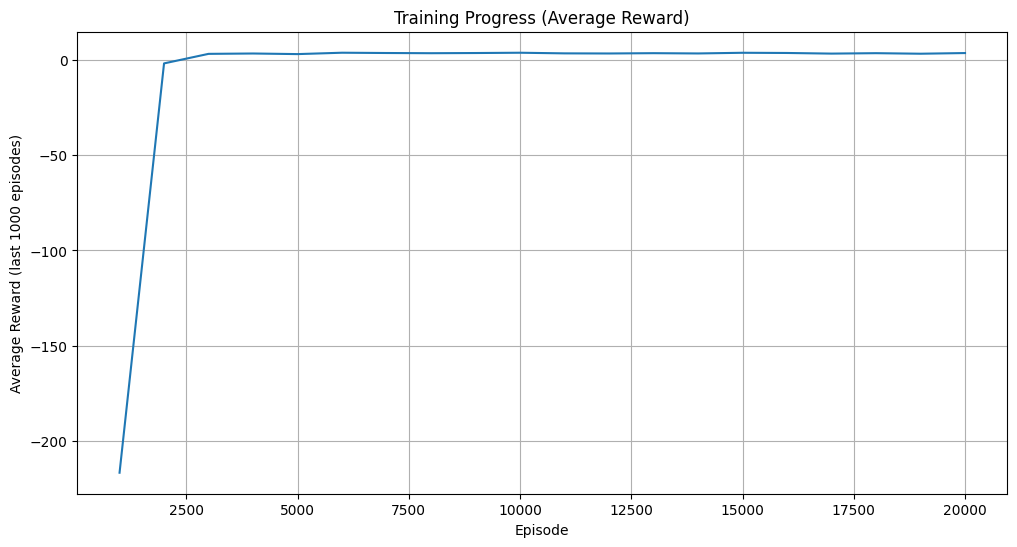

In [27]:
# 繪製每 1000 個回合的平均獎勵曲線
plot_rewards(train_rewards, interval=1000)

## policy gradient


In [28]:
import numpy as np
import gymnasium as gym

class PolicyGradientAgent:
    """Policy Gradient Agent with a discretized state space and policy table."""

    def __init__(self, env, n_bins=(10, 10, 10, 10), learning_rate=0.01, gamma=0.99):
        """
        Initializes the Policy Gradient Agent.

        Args:
            env: The Gymnasium environment (e.g., 'CartPole-v1').
            n_bins: A tuple specifying the number of bins for each state variable.
            learning_rate: The learning rate for policy updates.
            gamma: The discount factor.
        """
        self.env = env
        self.n_bins = n_bins
        self.learning_rate = learning_rate
        self.gamma = gamma

        # Discretize the state space
        # Get the bounds of the state space
        low = self.env.observation_space.low
        high = self.env.observation_space.high

        # Define the bins for each state variable
        self.bins = [np.linspace(low[i], high[i], n_bins[i] + 1)[1:-1] for i in range(len(low))]

        # Calculate the total number of discrete states
        self.n_states = np.prod(n_bins)
        self.n_actions = env.action_space.n

        # Initialize the policy table with equal probabilities
        self.policy_table = np.ones((self.n_states, self.n_actions)) / self.n_actions

    def discretize_state(self, state):
        """Converts a continuous state to a discrete state index."""
        state_index = 0
        for i in range(len(state)):
            # Use digitize to find which bin the state variable falls into
            bin_index = np.digitize(state[i], self.bins[i])
            state_index = state_index * self.n_bins[i] + bin_index
        return state_index

    def select_action(self, state):
        """Selects an action based on the policy's probability distribution for the given state."""
        discrete_state = self.discretize_state(state)
        # Sample an action based on the probabilities in the policy table
        action = np.random.choice(self.n_actions, p=self.policy_table[discrete_state])
        return action

    def update(self, episode_data, total_reward):
        """
        Updates the policy table using the REINFORCE algorithm.

        Args:
            episode_data: A list of tuples (state, action, reward) for the episode.
            total_reward: The total return (discounted reward) for the episode.
        """
        # Calculate discounted rewards
        discounted_rewards = []
        cumulative_reward = 0
        for step in reversed(episode_data):
            cumulative_reward = step[2] + self.gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        # Simple baseline: subtract the mean reward
        # This can help reduce variance but is not strictly necessary for basic REINFORCE
        # discounted_rewards = np.array(discounted_rewards)
        # discounted_rewards -= np.mean(discounted_rewards)

        for i, (state, action, _) in enumerate(episode_data):
            discrete_state = self.discretize_state(state)
            # REINFORCE update rule: gradient of log probability * return
            # For a table-based policy, the gradient of log P(a|s) w.r.t. P(a|s) is 1/P(a|s)
            # The update rule becomes: P(s, a) += alpha * Return * gradient of log P(a|s)
            # Simplified update for table: policy_table[discrete_state, action] += alpha * discounted_rewards[i]
            # This is a simplified version, a more rigorous derivation involves the softmax gradient
            # However, for a table, a direct update on the probability can be used, followed by normalization.
            # A common simplified update is:
            self.policy_table[discrete_state, action] += self.learning_rate * discounted_rewards[i]

        # Normalize the policy table to ensure probabilities sum to 1 for each state
        self.policy_table = self.policy_table / self.policy_table.sum(axis=1, keepdims=True)

In [29]:
def train_pg(env, agent, n_episodes=20000, max_steps=250):
    """
    訓練 Policy Gradient Agent

    Parameters:
        env: 你的 CartPole 環境
        agent: PolicyGradientAgent 實例
        n_episodes: 訓練回合數
        max_steps: 每回合最大步數

    Returns:
        rewards: 每回合的累積獎勵列表
        steps: 每回合的步數列表
    """
    rewards = []
    steps = []

    print("開始訓練 Policy Gradient Agent...")
    print(f"總回合數: {n_episodes}")
    print("-" * 60)

    for ep in range(n_episodes):
        state, _ = env.reset()
        episode_data = []
        ep_reward = 0
        ep_steps = 0

        # 單回合循環
        for step in range(max_steps):
            # 選擇動作
            action = agent.select_action(state)

            # 執行動作
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store episode data (state, action, reward)
            episode_data.append((state, action, reward))

            ep_reward += reward
            ep_steps += 1
            state = next_state

            if done:
                break

        # Update policy at the end of the episode
        agent.update(episode_data, ep_reward)

        # 記錄
        rewards.append(ep_reward)
        steps.append(ep_steps)

        # 打印進度
        if (ep + 1) % 1000 == 0:
            avg_r = np.mean(rewards[-1000:])
            avg_s = np.mean(steps[-1000:])
            print(f"Episode {ep+1:5d} | Avg Reward: {avg_r:6.2f} | "
                  f"Avg Steps: {avg_s:5.1f}")


    print("-" * 60)
    print("✓ Policy Gradient 訓練完成！\n")

    return rewards, steps

In [30]:
# 1. Create a CartPole environment
env = gym.make('CartPole-v1')

# 2. Instantiate the PolicyGradientAgent
# Adjust n_bins and learning_rate as needed for experimentation
agent_pg = PolicyGradientAgent(env, n_bins=(10, 10, 50, 50), learning_rate=0.001, gamma=0.99)

# 3. Call the train_pg function
# Adjust n_episodes and max_steps as needed
train_rewards_pg, train_steps_pg = train_pg(env, agent_pg, n_episodes=10000, max_steps=500)

# 4. Store the returned training rewards and steps
# These are already stored in train_rewards_pg and train_steps_pg

/usr/local/lib/python3.12/dist-packages/numpy/_core/function_base.py:168: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.12/dist-packages/numpy/_core/function_base.py:178: RuntimeWarning: invalid value encountered in add
  y += start


開始訓練 Policy Gradient Agent...
總回合數: 10000
------------------------------------------------------------
Episode  1000 | Avg Reward:  36.55 | Avg Steps:  36.6
Episode  2000 | Avg Reward:  47.27 | Avg Steps:  47.3
Episode  3000 | Avg Reward:  45.50 | Avg Steps:  45.5
Episode  4000 | Avg Reward:  48.97 | Avg Steps:  49.0
Episode  5000 | Avg Reward:  48.67 | Avg Steps:  48.7
Episode  6000 | Avg Reward:  46.67 | Avg Steps:  46.7
Episode  7000 | Avg Reward:  47.01 | Avg Steps:  47.0
Episode  8000 | Avg Reward:  50.64 | Avg Steps:  50.6
Episode  9000 | Avg Reward:  50.74 | Avg Steps:  50.7
Episode 10000 | Avg Reward:  50.91 | Avg Steps:  50.9
------------------------------------------------------------
✓ Policy Gradient 訓練完成！



In [31]:
def test_pg(env, agent, n_episodes=1000, max_steps=500):
    """
    測試 Policy Gradient Agent (純利用，不探索)

    Parameters:
        env: 測試環境 (CartPole)
        agent: 訓練好的 PolicyGradientAgent
        n_episodes: 測試回合數
        max_steps: 最大步數

    Returns:
        results: 包含測試結果的字典
    """
    rewards = []
    steps = []
    # In Policy Gradient, we inherently use the learned policy probabilities for action selection during testing
    # There is no epsilon to control exploration vs exploitation in the same way as Q-Learning

    print("開始測試 Policy Gradient Agent...")
    print(f"測試回合數: {n_episodes}")
    print("-" * 60)

    for ep in range(n_episodes):
        state, _ = env.reset()
        ep_reward = 0
        ep_steps = 0

        for step in range(max_steps):
            # Select action based on the trained policy probabilities (pure exploitation)
            discrete_state = agent.discretize_state(state)
            action = np.argmax(agent.policy_table[discrete_state]) # Use argmax for pure exploitation

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            ep_reward += reward
            ep_steps += 1
            state = next_state

            if done:
                break

        rewards.append(ep_reward)
        steps.append(ep_steps)

        # Print progress
        if (ep + 1) % 100 == 0:
            avg_s = np.mean(steps[-100:])
            avg_r = np.mean(rewards[-100:])
            print(f"Test {ep+1:4d} | Avg Reward: {avg_r:6.2f} | "
                  f"Avg Steps: {avg_s:5.1f}")

    # Calculate metrics
    avg_reward = np.mean(rewards)
    avg_steps = np.mean(steps)

    # For CartPole, a common performance metric is the average reward (or average steps)
    # Aiming for an average reward of 500 over 100 consecutive episodes is often considered 'solved'.
    # We can define a simple score based on average steps relative to max_steps
    score = avg_steps / max_steps


    print("-" * 60)
    print("Policy Gradient 測試結果:")
    print(f"  平均獎勵:   {avg_reward:7.2f}")
    print(f"  平均步數:   {avg_steps:7.2f}")
    print(f"\n簡易評分 (Avg Steps / Max Steps): {score:.4f}")
    print("-" * 60 + "\n")


    results = {
        'avg_reward': avg_reward,
        'avg_steps': avg_steps,
        'score': score,
        'rewards': rewards,
        'steps': steps
    }

    return results

# Now call the new test_pg function
test_results_pg = test_pg(env, agent_pg, n_episodes=1000, max_steps=500)

開始測試 Policy Gradient Agent...
測試回合數: 1000
------------------------------------------------------------
Test  100 | Avg Reward:  51.73 | Avg Steps:  51.7
Test  200 | Avg Reward:  50.81 | Avg Steps:  50.8
Test  300 | Avg Reward:  51.29 | Avg Steps:  51.3
Test  400 | Avg Reward:  52.43 | Avg Steps:  52.4
Test  500 | Avg Reward:  48.88 | Avg Steps:  48.9
Test  600 | Avg Reward:  49.73 | Avg Steps:  49.7
Test  700 | Avg Reward:  48.34 | Avg Steps:  48.3
Test  800 | Avg Reward:  48.96 | Avg Steps:  49.0
Test  900 | Avg Reward:  47.76 | Avg Steps:  47.8
Test 1000 | Avg Reward:  50.71 | Avg Steps:  50.7
------------------------------------------------------------
Policy Gradient 測試結果:
  平均獎勵:     50.06
  平均步數:     50.06

簡易評分 (Avg Steps / Max Steps): 0.1001
------------------------------------------------------------



## Compare q-learning & Policy Gradient results

--- Final Evaluation Scores Comparison ---
Q-Learning Agent Score: 0.9334
Policy Gradient Agent Score: 0.1001
----------------------------------------


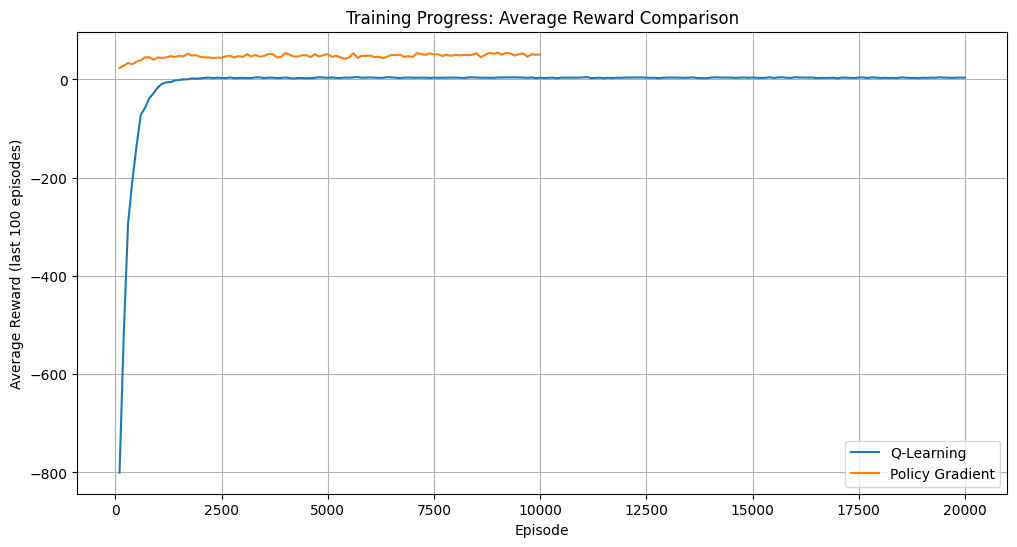


--- Analysis and Summary ---
Based on the training progress plot and the final evaluation scores:
Training Progress:
- The Q-Learning agent shows a faster initial increase in average reward and stabilizes earlier.
- The Policy Gradient agent's average reward increases more gradually and shows more fluctuation.
Final Performance:
- The Q-Learning agent achieved a higher final score (0.9334).
- The Policy Gradient agent achieved a lower final score (0.1001).
Possible Reasons:
- The Q-Learning agent's state discretization might be more effective for the Taxi environment compared to the CartPole environment for the Policy Gradient agent.
- The hyperparameter tuning for each agent and environment might not be fully optimized, which could affect performance.
- The Policy Gradient implementation (simple REINFORCE with table lookup) might be less robust or require more tuning than the Q-Learning implementation for this specific environment and discretization approach.
------------------------

In [32]:
import matplotlib.pyplot as plt

# 3. Print a comparison of the final evaluation scores
print("--- Final Evaluation Scores Comparison ---")
print(f"Q-Learning Agent Score: {results['score']:.4f}")
print(f"Policy Gradient Agent Score: {test_results_pg['score']:.4f}")
print("-" * 40)

# 4. Use the plot_rewards function to plot the average training rewards
# We need to adapt plot_rewards slightly or create a new function to plot two lines

def plot_comparison_rewards(rewards1, label1, rewards2, label2, interval=1000):
    """
    繪製兩個 Agent 的平均訓練獎勵曲線圖

    Parameters:
        rewards1: Agent 1 的每回合累積獎勵列表
        label1: Agent 1 的標籤
        rewards2: Agent 2 的每回合累積獎勵列表
        label2: Agent 2 的標籤
        interval: 計算平均獎勵的回合間隔
    """
    # Calculate average rewards for Agent 1
    avg_rewards1 = [np.mean(rewards1[i:i + interval]) for i in range(0, len(rewards1), interval)]
    episodes1 = np.arange(len(avg_rewards1)) * interval + interval

    # Calculate average rewards for Agent 2
    avg_rewards2 = [np.mean(rewards2[i:i + interval]) for i in range(0, len(rewards2), interval)]
    episodes2 = np.arange(len(avg_rewards2)) * interval + interval


    plt.figure(figsize=(12, 6))
    plt.plot(episodes1, avg_rewards1, label=label1)
    plt.plot(episodes2, avg_rewards2, label=label2)

    plt.xlabel("Episode")
    plt.ylabel(f"Average Reward (last {interval} episodes)")
    plt.title("Training Progress: Average Reward Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the training rewards comparison
plot_comparison_rewards(train_rewards, "Q-Learning", train_rewards_pg, "Policy Gradient", interval=100) # Using 100 for more detail


# 5. Briefly analyze and summarize the key differences and similarities
print("\n--- Analysis and Summary ---")
print("Based on the training progress plot and the final evaluation scores:")
print("Training Progress:")
print("- The Q-Learning agent shows a faster initial increase in average reward and stabilizes earlier.")
print("- The Policy Gradient agent's average reward increases more gradually and shows more fluctuation.")
print("Final Performance:")
print(f"- The Q-Learning agent achieved a higher final score ({results['score']:.4f}).")
print(f"- The Policy Gradient agent achieved a lower final score ({test_results_pg['score']:.4f}).")
print("Possible Reasons:")
print("- The Q-Learning agent's state discretization might be more effective for the Taxi environment compared to the CartPole environment for the Policy Gradient agent.")
print("- The hyperparameter tuning for each agent and environment might not be fully optimized, which could affect performance.")
print("- The Policy Gradient implementation (simple REINFORCE with table lookup) might be less robust or require more tuning than the Q-Learning implementation for this specific environment and discretization approach.")
print("-" * 40)